In [1]:
import hoomd
import hoomd.hpmc

# Store particle shape information in GSD files

## The GSD file format

[GSD](https://bitbucket.org/glotzer/gsd) is a binary file format designed specifically for HOOMD. It supports all of HOOMD's particle properties, is easy to configure, and fast to read and write. It can optionally store particle shape information from HPMC integrators for use in data analysis, visualization, and restartable jobs. `dump_state` also stores the  maximum move sizes `d` and `a`.

## Dump state to GSD files

Start with the hard square tutorial script.

In [2]:
hoomd.context.initialize('--mode=cpu');
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.2),
                                   n=10);
mc = hoomd.hpmc.integrate.convex_polygon(d=0.2, a=0.4, seed=1);
square_verts = [[-0.5, -0.5], [0.5, -0.5], [0.5, 0.5], [-0.5, 0.5]];
mc.shape_param.set('A', vertices=square_verts);

HOOMD-blue 2.2.3-unknown CUDA (9.1) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 02/06/2018
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 100 particles


One additional command activates GSD file writes every period steps.

In [3]:
d = hoomd.dump.gsd("trajectory.gsd", period=2e3, group=hoomd.group.all(), overwrite=True);

Instruct the gsd writer to dump state from the integrator every frame.

In [4]:
d.dump_state(mc)

In the subsequent run, the gsd writer will save frames every 2000 steps that include position, orientation, and shape information.

In [5]:
hoomd.run(10000, quiet=True);

## Read a GSD file for visualization/analysis
Use the `gsd` python module to open the file and inspect the shape and move size information. [Full GSD tutorials are are available in the gsd docs](http://gsd.readthedocs.io/en/latest/), including a [description of the format for state information](http://gsd.readthedocs.io/en/latest/schema-hoomd.html#state-data).


In [6]:
import gsd
import gsd.hoomd
t = gsd.hoomd.open('trajectory.gsd', 'rb');
last_frame = t[-1]

In [7]:
last_frame.state['hpmc/integrate/d'], last_frame.state['hpmc/integrate/a']

(array([0.2]), array([0.4]))

In [8]:
last_frame.state['hpmc/convex_polygon/N']

array([4], dtype=uint32)

In [9]:
last_frame.state['hpmc/convex_polygon/vertices']

array([[-0.5, -0.5],
       [ 0.5, -0.5],
       [ 0.5,  0.5],
       [-0.5,  0.5]], dtype=float32)

You can use this shape data in your visualization and analysis workflows. Here, use the `ex_render` helper to display the trajectory using the shape information from the gsd file.

[ex_render](ex_render.py) is a helper script that builds animated gifs from trajectory files and system snapshots. It is part of the [hoomd-examples](https://bitbucket.org/glotzer/hoomd-examples) repository and designed only to render these examples.

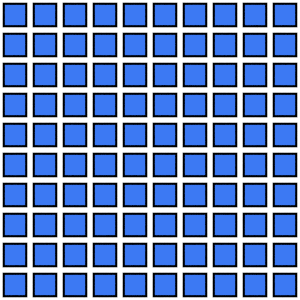

In [10]:
import ex_render
ex_render.display_movie(lambda x: ex_render.render_polygon_frame(x, last_frame.state['hpmc/convex_polygon/vertices']), 'trajectory.gsd');

## Use state information for restarting jobs

The state information in a GSD file may be used to start a new simulation run with the shape and move sizes stored in teh gsd file. This example creates a clean simulation context to emulate a separate script.

In [11]:
hoomd.context.initialize('--mode=cpu');

Read in the last frame of the trajectory. This command only reads in the particle positions and orientations.

In [12]:
hoomd.init.read_gsd('trajectory.gsd', frame=4);

notice(2): Group "all" created containing 100 particles


Pass `restore_state=True` to the MC integrator and it will read in the shape information from the gsd file ready by `init.read_gsd`.

In [13]:
mc = hoomd.hpmc.integrate.convex_polygon(restore_state=True, seed=1);

The move sizes and shape information were read from the file, so there is no need to set them. The simulation is ready to run.

In [14]:
mc.get_d()

0.2

In [15]:
mc.get_a()

0.4

In [16]:
print(mc.shape_param['A'])

convex polygon(vertices = [[-0.5, -0.5], [0.5, -0.5], [0.5, 0.5], [-0.5, 0.5]])


In [17]:
hoomd.run(10000, quiet=True);